In [78]:
# Required Modules

import talib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

# Custom Functions

In [79]:
def plot(y_train, y_test, y_train_pred, y_test_pred, timestamp, train_size):
    plt.plot(timestamp[:train_size], y_train, label="training(actual)")
    plt.plot(timestamp[train_size:], y_test, label="testing(actual)")
    plt.plot(timestamp[:train_size], y_train_pred, label="training(forecast)")
    plt.plot(timestamp[train_size:], y_test_pred, label="testing(forecast)")
    plt.legend()
    
    return

# Loading and Preprocessing data 

In [80]:
data = pd.read_csv('SBI_2015-01-01_2020-04-20.csv', index_col='Date')
data.index = pd.to_datetime(data.index)
print(data.head())
print()

sbi = data[['Adj Close']]
sbi.columns = ['Adj_Close']
print(sbi.head())

            Open  High   Low  Close  Adj Close  Volume
Date                                                  
2014-12-31  9.74  9.76  9.68   9.76   7.790193    7200
2015-01-02  9.64  9.70  9.63   9.65   7.702391   28500
2015-01-05  9.70  9.77  9.69   9.77   7.798174   11300
2015-01-06  9.82  9.82  9.74   9.77   7.798174   11800
2015-01-07  9.74  9.89  9.74   9.83   7.846069   13300

            Adj_Close
Date                 
2014-12-31   7.790193
2015-01-02   7.702391
2015-01-05   7.798174
2015-01-06   7.798174
2015-01-07   7.846069


# Expanding Feature Space

Indicators which I have selected are
* Relative Strength Index(RSI)
* Simple Moving Average(SMA)
* Rate Of Change Price(ROCP)

and calculated over the rolling windows of 7, 14, 30, 60

In [81]:
indicators = ['SMA', 'RSI', 'ROCP']
rolling_windows = [7, 14, 30, 60]
targets = ['Adj_Close']
features = []

for n in rolling_windows:
    for ind in indicators:
        col_name = "Adj_Close_"+ind+"_"+str(n)
        features.append(col_name)
        if ind == 'SMA':
            sbi[col_name] = talib.SMA(sbi['Adj_Close'], timeperiod=n)
        elif ind == 'RSI':
            sbi[col_name] = talib.RSI(sbi['Adj_Close'], timeperiod=n)
        elif ind == 'ROCP':
            sbi[col_name] = talib.ROCP(sbi['Adj_Close'], timeperiod=n)
sbi = sbi.dropna()
timestamp = sbi.index

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

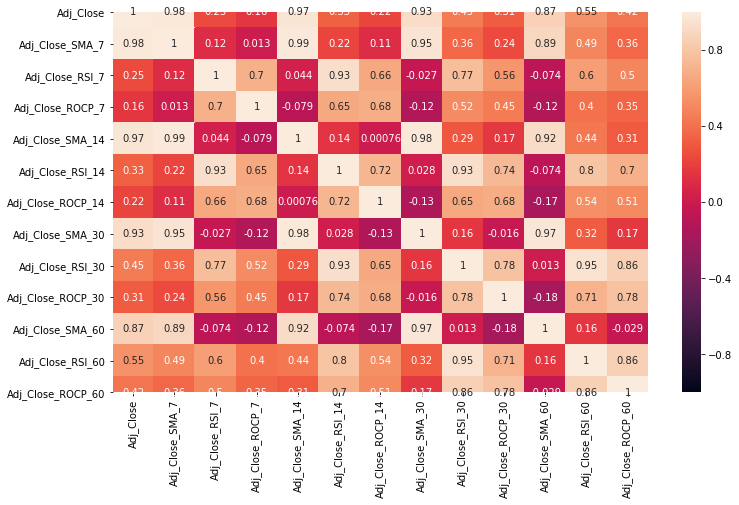

In [82]:
# Correlation Heatmap

sns.heatmap(sbi.corr(), vmin=-1, vmax=1, annot=True)

# Train Test Split

Dividing the entire data into training and testing sets, with testing size of 0.25

In [83]:
length = len(sbi)
train_ratio = 0.75
train_size = int(train_ratio * length)

X_train = sbi[features][:train_size]
y_train = sbi[targets][:train_size]
X_test = sbi[features][train_size:]
y_test = sbi[targets][train_size:]

# Model

In [84]:
# Defining the model

class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        
        self.fc1 = nn.Linear(12, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = torch.Tensor(x)
        x = x.view(-1, x.shape[0])
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        return x
    
model = Predictor()
print(model)

Predictor(
  (fc1): Linear(in_features=12, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [85]:
# Defining Optimizer and Loss function

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [86]:
epochs = 50
training_loss, testing_loss = [], []

for e in range(epochs):
    running_loss = 0
    for x, y in zip(X_train.values, y_train.values):
        optimizer.zero_grad()
        
        output = model.forward(x)
        y = torch.Tensor(y)
        loss = criterion(output, y)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        
        with torch.no_grad():
            model.eval()
            
            for x, y in zip(X_test.values, y_test.values):
                output = model.forward(x)
                y = torch.Tensor(y)
                loss = criterion(output, y)
                
                test_loss += loss.item()
        model.train()
        
    training_loss.append(running_loss/len(X_train))
    testing_loss.append(test_loss/len(X_test))
    print(f"Epochs: {e+1}/{epochs}.. Training Loss: {running_loss/len(X_train):3f}.. Testing Loss: {test_loss/len(X_test):3f}..\n")

Epochs: 1/50.. Training Loss: 21.148685.. Testing Loss: 13.095005..

Epochs: 2/50.. Training Loss: 15.165856.. Testing Loss: 7.862116..

Epochs: 3/50.. Training Loss: 13.931540.. Testing Loss: 6.659922..

Epochs: 4/50.. Training Loss: 14.790336.. Testing Loss: 6.308934..

Epochs: 5/50.. Training Loss: 16.353722.. Testing Loss: 5.966160..

Epochs: 6/50.. Training Loss: 14.748785.. Testing Loss: 6.035129..

Epochs: 7/50.. Training Loss: 15.356051.. Testing Loss: 5.923758..

Epochs: 8/50.. Training Loss: 16.569790.. Testing Loss: 5.740301..

Epochs: 9/50.. Training Loss: 13.685110.. Testing Loss: 5.991632..

Epochs: 10/50.. Training Loss: 14.811220.. Testing Loss: 5.980444..

Epochs: 11/50.. Training Loss: 15.739663.. Testing Loss: 5.919552..

Epochs: 12/50.. Training Loss: 14.556461.. Testing Loss: 5.882740..

Epochs: 13/50.. Training Loss: 15.663212.. Testing Loss: 5.882251..

Epochs: 14/50.. Training Loss: 14.720550.. Testing Loss: 5.877047..

Epochs: 15/50.. Training Loss: 15.108663..

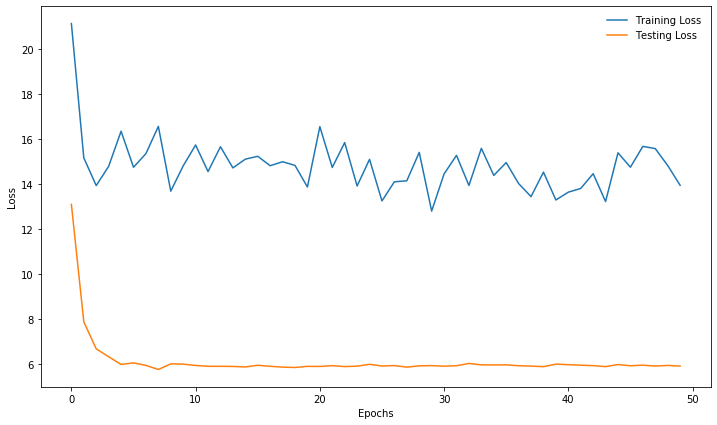

In [87]:
# Plotting Loss vs Epochs

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(training_loss, label="Training Loss")
plt.plot(testing_loss, label="Testing Loss")
plt.legend(frameon=False)